In [1]:
using Plots
import Plots: plot!, vline!
using LinearAlgebra

In [2]:
mutable struct WienerProcess{T<:Number}
    mu::T
    sigma2::T
    timestep::T
    values::Vector{T}
    steps::Int
    times::Vector{T}

    # Constructeur pour initialiser le processus sans valeurs simulées
    function WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number
        new{T}(mu, sigma2, timestep, Vector{T}(), steps, collect(0:timestep:steps * timestep))
    end
end

In [3]:
# Fonction pour simuler le processus de Wiener
function simulate!(wp::WienerProcess)
    sqrt_sigma2 = sqrt(wp.sigma2)
    wp.values = [0.0]
    for t in 1:wp.steps
        dt = wp.timestep
        dW = sqrt_sigma2 * sqrt(dt) * randn()
        new_value = wp.values[end] + wp.mu * dt + dW
        push!(wp.values, new_value)
    end
end

simulate! (generic function with 1 method)

In [4]:
# Méthode pour tracer le processus de Wiener
function plot!(process::WienerProcess)
    # Tracer le processus de Wiener
    plot!(process.times, process.values, xlabel="Time", ylabel="Wiener Process", label="Wiener Process", 
    linestyle=:dash, markershape=:circle, markercolor=:blue)
    
    # Tracer la droite mu*t
    plot!(process.times, process.mu .* process.times, label="mu*t", linestyle=:dash)
end

plot! (generic function with 5 methods)

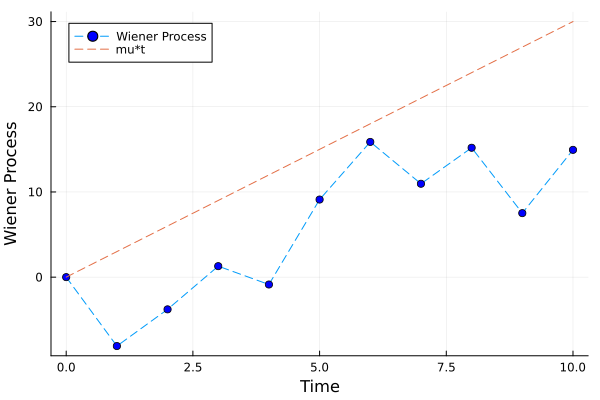

In [5]:
# Définir les paramètres du processus de Wiener
mu = 3.0
sigma2 = 50.0
timestep = 1.
steps = 10

# Créer une instance de WienerProcess
process = WienerProcess{Float64}(mu, sigma2, timestep, steps)

# Simuler le processus de Wiener
simulate!(process)

plot()
# Tracer le processus de Wiener simulé
plot!(process)

In [6]:
mutable struct WienerARD1
    underlying_process::WienerProcess{Float64}
    rho::Float64
    maintenance_times::Vector{Float64}
    k::Int
    values::Vector{Vector{Float64}}
    new_times::Vector{Vector{Float64}}

    function WienerARD1(mu::Float64, sigma2::Float64, timestep::Float64, steps::Int, rho::Float64, maintenance_times::Vector{Float64})
        underlying_process = WienerProcess{Float64}(mu, sigma2, timestep, steps)
        simulate!(underlying_process)
        
        k = length(maintenance_times)
        
        # Initialize new_times array
        new_times = Vector{Vector{Float64}}()
        start_time = 0.0
        
        # Populate new_times with intervals up to each maintenance time
        for i in 1:length(maintenance_times)
            end_time = maintenance_times[i]
            push!(new_times,collect(start_time:timestep:end_time))
            start_time = end_time
        end
        
        # Last segment from last maintenance time to the end
        push!(new_times, collect(start_time:timestep:(steps * timestep)))
        
        new(underlying_process, rho, maintenance_times, k, Vector{Vector{Float64}}(), new_times)
    end
end

In [7]:
function simulate!(process::WienerARD1)
    
    # Créer un vecteur Y initialisé avec les valeurs de X
    Y = copy(process.underlying_process.values)
    
    # Modifier les valeurs de Y selon les règles spécifiées
    for i in 1:length(process.maintenance_times) - 1
        maintenance_time = process.maintenance_times[i]
        next_maintenance_time = process.maintenance_times[i+1]
        
        # Indices des temps entre deux instants de maintenance
        indices = findall(t -> t > maintenance_time && t <= next_maintenance_time, process.underlying_process.times)
        
        # Mettre à jour les valeurs de Y
        Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]  
    end
    
    indices = findall(t -> t > process.maintenance_times[length(process.maintenance_times)], process.underlying_process.times)
    Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]

    new_values = Float64[]

    last_before_maintenance = findlast(t -> t <= process.maintenance_times[1], process.underlying_process.times)

    if last_before_maintenance !== nothing
        # Concatenate the part before last_before_maintenance into new_values
        append!(new_values, Y[1:last_before_maintenance])
    end

    for i in 1:length(process.maintenance_times) -1
        mtn_time = process.maintenance_times[i]
        next_mtn_time = process.maintenance_times[i+1]
        between_maintenances = findall(t -> t > mtn_time && t<=next_mtn_time, process.underlying_process.times)
        if !isempty(between_maintenances)
            # Concatenate the part before last_before_maintenance into new_values
            append!(new_values, (1 - process.rho) * process.underlying_process.values[between_maintenances[1]-1])
            append!(new_values, Y[between_maintenances])
        end
    end
    
    m = findfirst(t -> t == process.maintenance_times[end], process.underlying_process.times)
    append!(new_values, (1 - process.rho) * process.underlying_process.values[m])
    append!(new_values, Y[m+1:end])

    t1 = 1
    t2 = 0
   for i in 1:process.k+1
        t2 = length(process.new_times[i]) + t2
        push!(process.values, new_values[t1:t2])
        t1 = t2 + 1
   end
end

simulate! (generic function with 2 methods)

In [8]:
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 10
rho = 0.3
maintenance_times = [ 3. * i for i in 1:2]

# Créer une instance de WienerProcess
processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(processARD1)


In [9]:
# Méthode pour tracer le processus de Wiener avec les temps de maintenance
function plot!(process::WienerARD1)
    # Tracer le processus de Wiener
    # plot(process.underlying_process.times, process.values, xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process", legend=:topright)
    plot(xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process")
    for i in 1:process.k+1
        plot!(process.new_times[i], process.values[i], linestyle=:dash, markershape=:circle, markercolor=:red, color=:blue, legend=:false)
    end
    # Tracer la droite mu*t
    plot!(process.underlying_process.times, process.underlying_process.mu .* process.underlying_process.times, label="mu*t", linestyle=:dash)

    vline!(process.maintenance_times, label="Maintenance Time", color=:red)
end


plot! (generic function with 6 methods)

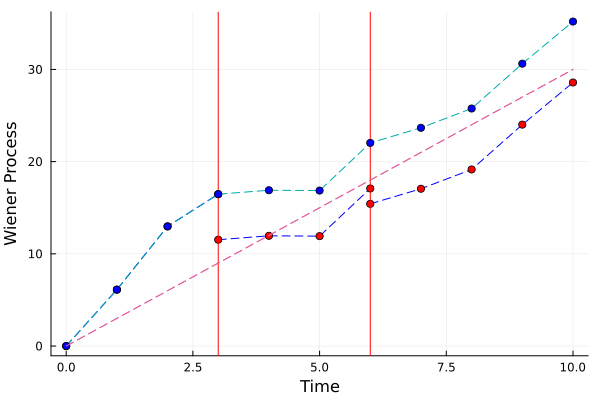

In [10]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(processARD1)
plot!(processARD1.underlying_process)

In [11]:
processARD1.values

3-element Vector{Vector{Float64}}:
 [0.0, 6.118613342326032, 12.975833154424766, 16.472070231236412]
 [11.530449161865487, 11.95696163567995, 11.919183379389494, 17.0900020003122]
 [15.422136148778186, 17.059883106653025, 19.150531197642263, 24.012162790679884, 28.581496039129068]

In [12]:
processARD1.underlying_process.values

11-element Vector{Float64}:
  0.0
  6.118613342326032
 12.975833154424766
 16.472070231236412
 16.898582705050874
 16.86080444876042
 22.031623069683125
 23.669370027557964
 25.7600181185472
 30.621649711584823
 35.190982960034006

In [13]:
18.91056633994406 - 14.557774552619039

4.352791787325023

In [14]:
0.3 * (20.796820789455772 - 6.287514831705699)

4.352791787325022

In [15]:
function indicatrice(j::Int)
    return j > 1
end

indicatrice (generic function with 1 method)

In [16]:
# Initialize Sigma matrix
function Sigma(rho::Float64, ps::WienerARD1)
    n = length(ps.maintenance_times)
    Sigma = Matrix{Float64}(undef, n, n)

    # Populate Sigma using array comprehensions
    Sigma .= [
        i == j ? ps.underlying_process.timestep + rho^2 * ps.underlying_process.timestep * indicatrice(j) + (1 - rho)^2 * ps.underlying_process.timestep :               # Diagonal elements
        i == j + 1 || i == j - 1 ?  # Off-diagonal elements
        -rho * ps.underlying_process.timestep :                      # If adjacent
        0.0                         # Otherwise
        for i in 1:n, j in 1:n
    ]

    return Sigma
end

Sigma (generic function with 1 method)

In [17]:
Sigma(0.3, processARD1)

2×2 Matrix{Float64}:
  1.49  -0.3
 -0.3    1.58

In [18]:
function u(j::Int, rho::Float64, ps::WienerARD1)
    return ps.underlying_process.timestep - rho * ps.underlying_process.timestep * indicatrice(j) + (1 - rho) * ps.underlying_process.timestep
end

u (generic function with 1 method)

In [19]:
function v(j::Int, rho::Float64, ps::WienerARD1)
    
    diff_values = diff(ps.values[j])
    
    if j == 1 
        diff_values = diff_values[1:end-1]  # Exclude the last element
    elseif j == ps.k + 1
        diff_values = diff_values[2:end]
    else
        diff_values = diff_values[2:end-1]  # Exclude the first and last elements
    end
    result = rho * sum(diff_values)
    return result
end

v (generic function with 1 method)

In [20]:
v(1, rho, processARD1)

3.8927499463274295

In [21]:
function delta_y(ps::WienerARD1)
    differences = Float64[]

    # Parcourir les données
    for j in 1:ps.k + 1
        diff_values = diff(ps.values[j])
    
        if j == 1 
            diff_values = diff_values[1:end-1]  # Exclude the last element
        elseif j == ps.k + 1
            diff_values = diff_values[2:end]
        else
            diff_values = diff_values[2:end-1]  # Exclude the first and last elements
        end
        append!(differences, diff_values)
    end

    return differences
end

delta_y(processARD1)

6-element Vector{Float64}:
  6.118613342326032
  6.857219812098734
 -0.03777825629045495
  2.0906480909892373
  4.861631593037622
  4.569333248449183

In [22]:
function z(ps::WienerARD1)
    # Initialiser un vecteur pour stocker les différences successives
    differences = Float64[]

    # Parcourir les données
    for i in 1:ps.k
        push!(differences, ps.values[i + 1][2] - ps.values[i][end - 1])
    end

    return differences
end

println(z(processARD1))

[-1.0188715187448167, 5.140699727263531]


In [23]:
function mu_chapeau(rho::Float64, ps::WienerARD1)
    # Calculer l'inverse de Sigma
    Sigma_inv = inv(Sigma(rho, ps))
    V = [v(j, rho, ps) for j in 1:size(Sigma_inv)[1]] #/
    
    U = [u(j, rho, ps) for j in 1:length(V)] #/
    
    Z = z(ps) #/
    # display(Z)
    
    # Calculer le produit transpose(u) * Sigma_inv_v
    a = dot(U, Sigma_inv * Z)

    b = dot(U, Sigma_inv * V)
    
    c = sum(delta_y(ps))
    
    d = dot(U, Sigma_inv * U)

    e = length(delta_y(ps)) * ps.underlying_process.timestep

    return (a + b + c) / (d + e)
end

mu_chapeau (generic function with 1 method)

In [24]:
mu_chapeau(processARD1.rho, processARD1)

3.4499720479345006

In [25]:
processARD1

WienerARD1(WienerProcess{Float64}(3.0, 5.0, 1.0, [0.0, 6.118613342326032, 12.975833154424766, 16.472070231236412, 16.898582705050874, 16.86080444876042, 22.031623069683125, 23.669370027557964, 25.7600181185472, 30.621649711584823, 35.190982960034006], 10, [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]), 0.3, [3.0, 6.0], 2, [[0.0, 6.118613342326032, 12.975833154424766, 16.472070231236412], [11.530449161865487, 11.95696163567995, 11.919183379389494, 17.0900020003122], [15.422136148778186, 17.059883106653025, 19.150531197642263, 24.012162790679884, 28.581496039129068]], [[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0], [6.0, 7.0, 8.0, 9.0, 10.0]])

In [26]:
0.3 * ( 13.592408677378724 - 7.285516775897254 )

1.892067570444441

In [27]:
0.3 * sum(diff(processARD1.values[1]))

4.941621069370924

In [28]:
function sigma2_chapeau(rho::Float64, ps::WienerARD1)
    
    Sigma_inv = inv(Sigma(rho, ps))

    V = [v(j, rho, ps) for j in 1:size(Sigma_inv)[1]]

    U = [u(j, rho, ps) for j in 1:length(V)]

    Z = z(ps)

    # Calculer le produit transpose(u) * Sigma_inv_v
    a = Z - mu_chapeau(rho, ps) .* U + V

    b = dot(a, Sigma_inv * a)
    
    diffs = delta_y(ps)

    d = sum((dy_j - mu_chapeau(rho, ps))^2 for dy_j in diffs)

    N = sum(length(ps.values[i]) for i in 1:ps.k + 1) - 2 * ps.k - 2
    
    return (b + d) / N
end

sigma2_chapeau (generic function with 1 method)

In [29]:
function estimateur_rho_chapeau()

    rhos = [ 0.1 * i for i in 1:10]

    N = sum(length(processARD1.values[i]) for i in 1:processARD1.k + 1) - 2 * processARD1.k - 2

    f = [N * log(sigma2_chapeau(rho, processARD1)) / 2 + log(det(Sigma(rho, processARD1))) / 2 for rho in rhos]

    return rhos[argmin(f)]
end

estimateur_rho_chapeau (generic function with 1 method)

In [30]:
N = sum(length(processARD1.values[i]) for i in 1:processARD1.k + 1) - 2 * processARD1.k - 2

7

In [31]:
estimateur_rho_chapeau()

0.5

In [32]:
sigma2_chapeau(processARD1.rho, processARD1)

6.007660684546718

In [33]:
processARD1

WienerARD1(WienerProcess{Float64}(3.0, 5.0, 1.0, [0.0, 6.118613342326032, 12.975833154424766, 16.472070231236412, 16.898582705050874, 16.86080444876042, 22.031623069683125, 23.669370027557964, 25.7600181185472, 30.621649711584823, 35.190982960034006], 10, [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]), 0.3, [3.0, 6.0], 2, [[0.0, 6.118613342326032, 12.975833154424766, 16.472070231236412], [11.530449161865487, 11.95696163567995, 11.919183379389494, 17.0900020003122], [15.422136148778186, 17.059883106653025, 19.150531197642263, 24.012162790679884, 28.581496039129068]], [[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0], [6.0, 7.0, 8.0, 9.0, 10.0]])

In [34]:
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 100
rho = 0.3
maintenance_times = [ 10. * i for i in 1:9]
estimations = []

for i in 1:100
    # Créer une instance de WienerProcess
    processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
    simulate!(processARD1)
    push!(estimations, estimateur_rho_chapeau())
end

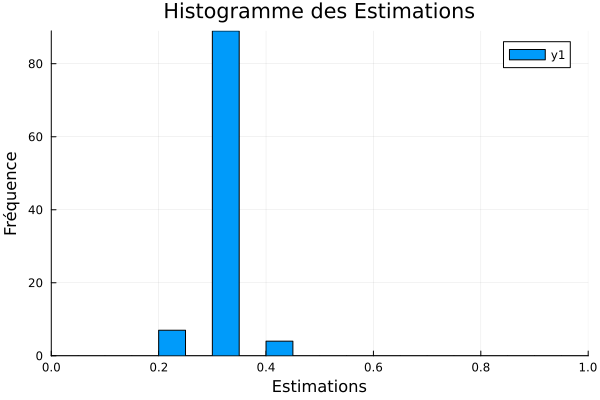

In [35]:
histogram(estimations, bins=0:0.05:1, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations", xlims=(0, 1))

In [36]:
println(estimations)

Any[0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.4, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.4, 0.30000000000000004, 0.30000000000000004, 0.2, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.3000000000000